In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import scipy.io
import numpy as np
from scipy.stats import pearsonr
# mat_data = scipy.io.loadmat('E:/data/Ca_analyzing/Calb1_all_ca/final/tail_licking.mat')
# tail_licking = mat_data['tail_licking']
# mat_data = scipy.io.loadmat('E:/data/Ca_analyzing/Calb1_all_ca/final/tail_attacking.mat')
# tail_attacking= mat_data['tail_attacking']

# mat_data = scipy.io.loadmat('E:/data/tnc miniscope/Tnc-all/final/tail_licking.mat')
# tail_licking_tnc = mat_data['tail_licking']
# mat_data = scipy.io.loadmat('E:/data/tnc miniscope/Tnc-all/final/tail_attacking.mat')
# tail_attacking_tnc= mat_data['tail_attacking']

mat_data = scipy.io.loadmat('E:/data/Ca_analyzing/affinity/tail_licking_re.mat')
tail_licking_all = mat_data['tail_licking_re']
mat_data = scipy.io.loadmat('E:/data/Ca_analyzing/affinity/tail_attacking_re.mat')# 根据shuffle顺序调整过后的数据
tail_attacking_all= mat_data['tail_attacking_re']


mat_data = scipy.io.loadmat('E:/data/Ca_analyzing/affinity/lick_average_mean.mat')
ensemble_lick = mat_data['lick_average_mean']
ensemble_lick=ensemble_lick.T.reshape(222)
mat_data = scipy.io.loadmat('E:/data/Ca_analyzing/affinity/attack_average_mean.mat')
ensemble_attack= mat_data['attack_average_mean']
ensemble_attack=ensemble_attack.T.reshape(222)

In [30]:
import h5py
import numpy as np

def load_mat_variable(file_path, var_name):
    with h5py.File(file_path, 'r') as f:
        data = f[var_name]
        # 转置并解引用（HDF5 存储为 Fortran-style column-major）
        if isinstance(data[0][0], h5py.Reference):
            # 多维结构（常见于 cell 数组）
            shape = data.shape
            output = np.empty(shape, dtype=object)
            for i in range(shape[0]):
                for j in range(shape[1]):
                    ref = data[i][j]
                    output[i][j] = np.array(f[ref])
            return output
        else:
            return np.array(data)

# # 加载 licking 数据
lick_file = 'E:/data/Ca_analyzing/Calb1_all_ca/final/lick_attack-shuffle/lick_shuffle.mat'
tail_licking_shuffle = load_mat_variable(lick_file, 'all_l_dff')
tail_licking_shuffle=tail_licking_shuffle.T

# 加载 attacking 数据
attack_file = 'E:/data/Ca_analyzing/Calb1_all_ca/final/lick_attack-shuffle/attack_shuffle.mat'
tail_attack_shuffle = load_mat_variable(attack_file, 'all_u_dff')
tail_attack_shuffle=tail_attack_shuffle.T



In [2]:
n=tail_licking_all.shape[1]
T = 222  #  n个神经元，T 个时间点 
baseline = 5  # 事件对齐点 (s)
offset = 3  # 事件对齐前后选取的时长 (s)
Fs=14.854
# 计算时间窗口索引
start_idx = int((baseline - offset) * Fs)
end_idx = int((baseline + offset) * Fs)

#求affinity
lick_affinity = np.zeros(n)
attack_affinity = np.zeros(n)
for neuron_idx in range(n):

    # 获取当前神经元的 lick 和 attack 试验
    lick_trials = tail_licking_all[0][neuron_idx] 
    attack_trials = tail_attacking_all[0][neuron_idx]  

    # 取出感兴趣的时间窗口数据
    lick_response = lick_trials[:,:]  
    attack_response = attack_trials[:,:] 
    neuron_lick=lick_response.mean(axis=0)
    neuron_attack=attack_response.mean(axis=0)
     # Pearson 相关性作为 affinity
    lick_affinity[neuron_idx], _ = pearsonr(neuron_lick, ensemble_lick)
    attack_affinity[neuron_idx], _ = pearsonr(neuron_attack, ensemble_attack)



In [31]:
n=tail_attack_shuffle.shape[1]
T = 222  #  n个神经元，T 个时间点 
baseline = 5  # 事件对齐点 (s)
offset = 3  # 事件对齐前后选取的时长 (s)
Fs=14.854
# 计算时间窗口索引
start_idx = int((baseline - offset) * Fs)
end_idx = int((baseline + offset) * Fs)

#求affinity
lick_affinity_shuffle = np.zeros(n)
attack_affinity_shuffle = np.zeros(n)
for neuron_idx in range(n):

    # 获取当前神经元的 lick 和 attack 试验
    lick_trials = tail_licking_shuffle[0][neuron_idx].T 
    attack_trials = tail_attack_shuffle[0][neuron_idx].T  

    # 取出感兴趣的时间窗口数据
    lick_response = lick_trials[:,0:222]  
    attack_response = attack_trials[:,0:222] 
    neuron_lick=lick_response.mean(axis=0)
    neuron_attack=attack_response.mean(axis=0)
     # Pearson 相关性作为 affinity
    lick_affinity_shuffle[neuron_idx], _ = pearsonr(neuron_lick, ensemble_lick)
    attack_affinity_shuffle[neuron_idx], _ = pearsonr(neuron_attack, ensemble_attack)
    

In [32]:
import numpy as np

lick_affinity_shuffle=lick_affinity_shuffle.reshape(262,1000)
p_values_lick = np.mean(
    np.abs(lick_affinity_shuffle) >= np.abs(lick_affinity[:, None]),
    axis=1
)
attack_affinity_shuffle=attack_affinity_shuffle.reshape(262,1000)
p_values_attack=np.mean(
    np.abs(attack_affinity_shuffle) >= np.abs(attack_affinity[:, None]),
    axis=1
)


In [46]:
significant_count_lick = np.sum(p_values_lick <= 0.05)
sig_indices_lick = np.where(p_values_lick <= 0.05)[0]
print(f"有 {sig_indices_lick} 个神经元在 shuffle test 中lick affinity 显著")
sig_indices_attack = np.where(p_values_attack <= 0.05)[0]
print(f"有 {sig_indices_attack} 个神经元在 shuffle test 中attack affinity 显著") 

有 [ 11  13  18  24  27  28  30  31  41  51  57  59  61  65  67  89  92  94
 103 109 110 122 123 128 130 132 133 137 138 161 166 175 179 189 206 210
 211 212 245 247 257 260 261] 个神经元在 shuffle test 中lick affinity 显著
有 [ 21  27  31  41  44  73  83  94  98 103 112 115 119 121 129 130 148 149
 157 162 185 192 194 208 232 249] 个神经元在 shuffle test 中attack affinity 显著


e:\anaconda\envs\neuronVis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


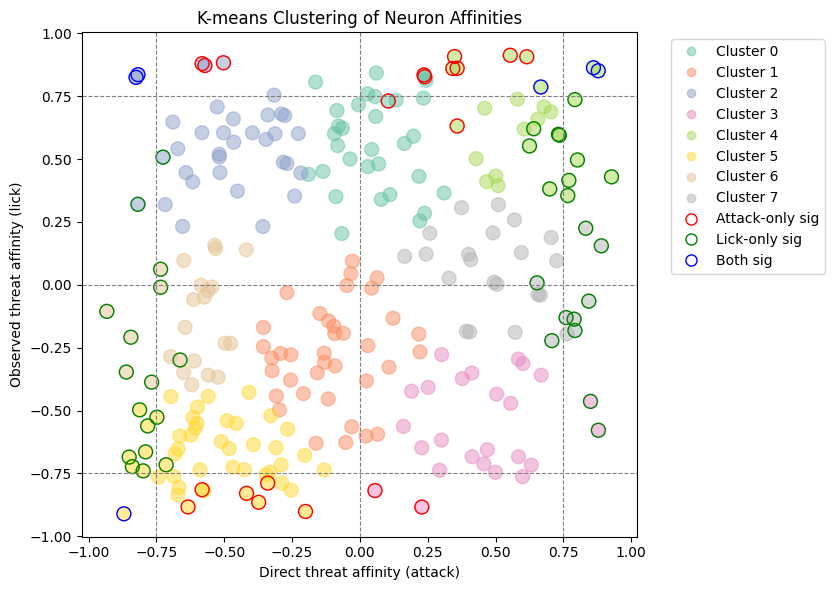

In [ ]:

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
# 分类掩码
both_sig = (p_values_attack <= 0.05) & (p_values_lick <= 0.05)
attack_only_sig = (p_values_attack <= 0.05) & (p_values_lick >= 0.05)
lick_only_sig = (p_values_lick <= 0.05) & (p_values_attack >= 0.05)

# K-means 原始图（背景）
X = np.vstack([lick_affinity, attack_affinity]).T
kmeans = KMeans(n_clusters=8, random_state=0)
labels = kmeans.fit_predict(X)

plt.figure(figsize=(8.5, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='Set2', s=100, alpha=0.5)
mpl.rcParams['pdf.fonttype'] = 42  # TrueType, AI 可编辑
mpl.rcParams['ps.fonttype'] = 42  
#添加边框标注：三种显著性类别
plt.scatter(X[attack_only_sig, 0], X[attack_only_sig, 1], 
            facecolors='none', edgecolors='red', s=100, label='Attack-only sig')

plt.scatter(X[lick_only_sig, 0], X[lick_only_sig, 1], 
            facecolors='none', edgecolors='green', s=100, label='Lick-only sig')

plt.scatter(X[both_sig, 0], X[both_sig, 1], 
            facecolors='none', edgecolors='blue', s=100, label='Both sig')

# 中心线
for v in [0, 0.75, -0.75]:
    plt.axhline(v, linestyle='--', color='gray', linewidth=0.8)
    plt.axvline(v, linestyle='--', color='gray', linewidth=0.8)

plt.xlabel("Lick affinity")
plt.ylabel("Attack affinity")
plt.title("K-means Clustering of Neuron Affinities")

# 图例（聚类 + 显著性）
handles, _ = scatter.legend_elements()
legend_labels = [f"Cluster {i}" for i in np.unique(labels)]
handles += [
    plt.Line2D([0], [0], marker='o', color='w', label='Attack-only sig',
               markerfacecolor='none', markeredgecolor='red', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='Lick-only sig',
               markerfacecolor='none', markeredgecolor='green', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='Both sig',
               markerfacecolor='none', markeredgecolor='blue', markersize=8)
]
legend_labels += ['Attack-only sig', 'Lick-only sig', 'Both sig']
# plt.xticks([])
# plt.yticks([])
plt.legend(handles, legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(False)
plt.savefig("D:/Figure/25/Figuer2/affinity_kmeans_cluster_backgroud.pdf", format="pdf")
plt.show()
